# Single sample scATAC-seq pipeline with snapATAC2
**Author**: Adam Klie (last modified: 10/24/2023)<br>
***
**Description**: This script performs the standard single sample SnapATAC2 pipeline.

In [1]:
# Imports
import os
import time
import logging
import argparse
from tqdm.auto import tqdm
import snapatac2 as snap
import scanpy as sc
print(snap.__version__)
print(sc.__version__)

2.3.1
1.9.3


In [20]:
# I/O
frag_file = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/processed/23Oct23/chromap/MM129/aln.bed"
min_load_tsse = 4
sorted_by_barcode = False
min_load_num_fragments = 1000
chunk_size = 1000000
low_memory = False

# QC and filtering
min_tsse = 12
min_num_fragments = 2000
max_num_fragments = 50000

# Feature selection
bin_size = 5000
num_features = 50000

# Analysis
clustering_resolution = 1

# Output
output_prefix = "snap2_single_sample_pipeline"
outdir_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/cellcommander/MM129"

In [21]:
# If output directory does not exist, create it.
if not os.path.exists(outdir_path):
    os.makedirs(outdir_path)

# Read fragment file

In [18]:
# Load in from fragment file into memory
adata = snap.pp.import_data(
    fragment_file=frag_file,
    genome=snap.genome.hg38,
    min_tsse=min_load_tsse,
    min_num_fragments=min_load_num_fragments,
    sorted_by_barcode=sorted_by_barcode,
    chunk_size=chunk_size,
    low_memory=low_memory,
)

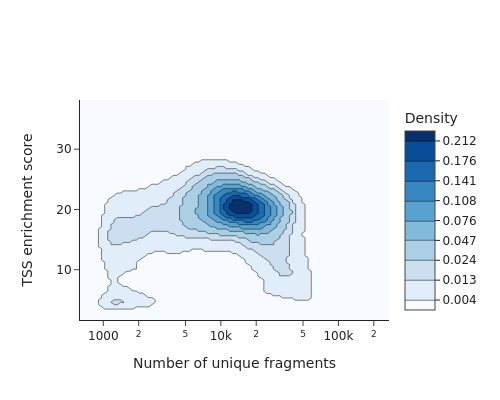

In [22]:
# Plot TSSe distribution vs number of fragments
snap.pl.tsse(adata, interactive=False)

# QC and filtering

In [23]:
# Filter out low quality cells
snap.pp.filter_cells(adata, min_tsse=min_tsse, min_counts=min_num_fragments, max_counts=max_num_fragments)

In [24]:
# Add a 5kb tile matrix
snap.pp.add_tile_matrix(adata, bin_size=bin_size)

In [25]:
# Select the top accessible features
snap.pp.select_features(adata, n_features=num_features)

2023-10-24 16:16:02 - INFO - Selected 50000 features.


In [26]:
# Run scrublet
snap.pp.scrublet(adata)

In [27]:
# Filter out doublets
snap.pp.filter_doublets(adata)

2023-10-24 16:21:43 - INFO - Detected doublet rate = 5.562%


In [29]:
# Save the processed data
adata.write(os.path.join(outdir_path, f"qc.h5ad"))

# Dimensionality reduction and clustering

In [30]:
# Run the spectral embedding
snap.tl.spectral(adata)

In [31]:
# Run UMAP
snap.tl.umap(adata)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite

In [32]:
# Find nearest neighbor graph
snap.pp.knn(adata, use_rep="X_spectral")

In [33]:
# Cluster data
snap.tl.leiden(adata, resolution=clustering_resolution)

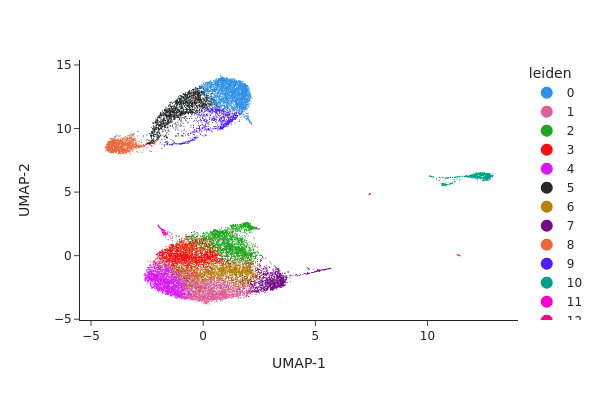

In [36]:
# Plot the UMAP with clusters
snap.pl.umap(adata, color="leiden", interactive=False)

In [37]:
# Save updated data
adata.write(os.path.join(outdir_path, f"clustered.h5ad"))

# Gene activity

In [39]:
# Create a gene matrix
gene_matrix = snap.pp.make_gene_matrix(
    adata=adata,
    gene_anno=snap.genome.hg38
)

In [40]:
# Clean up the gene matrix
sc.pp.filter_genes(gene_matrix, min_cells=3)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)

In [41]:
# Run MAGIC
sc.external.pp.magic(gene_matrix, solver="approximate")

In [42]:
# Transfer the UMAP from the original data to the gene matrix
gene_matrix.obsm["X_umap"] = adata.obsm["X_umap"]

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



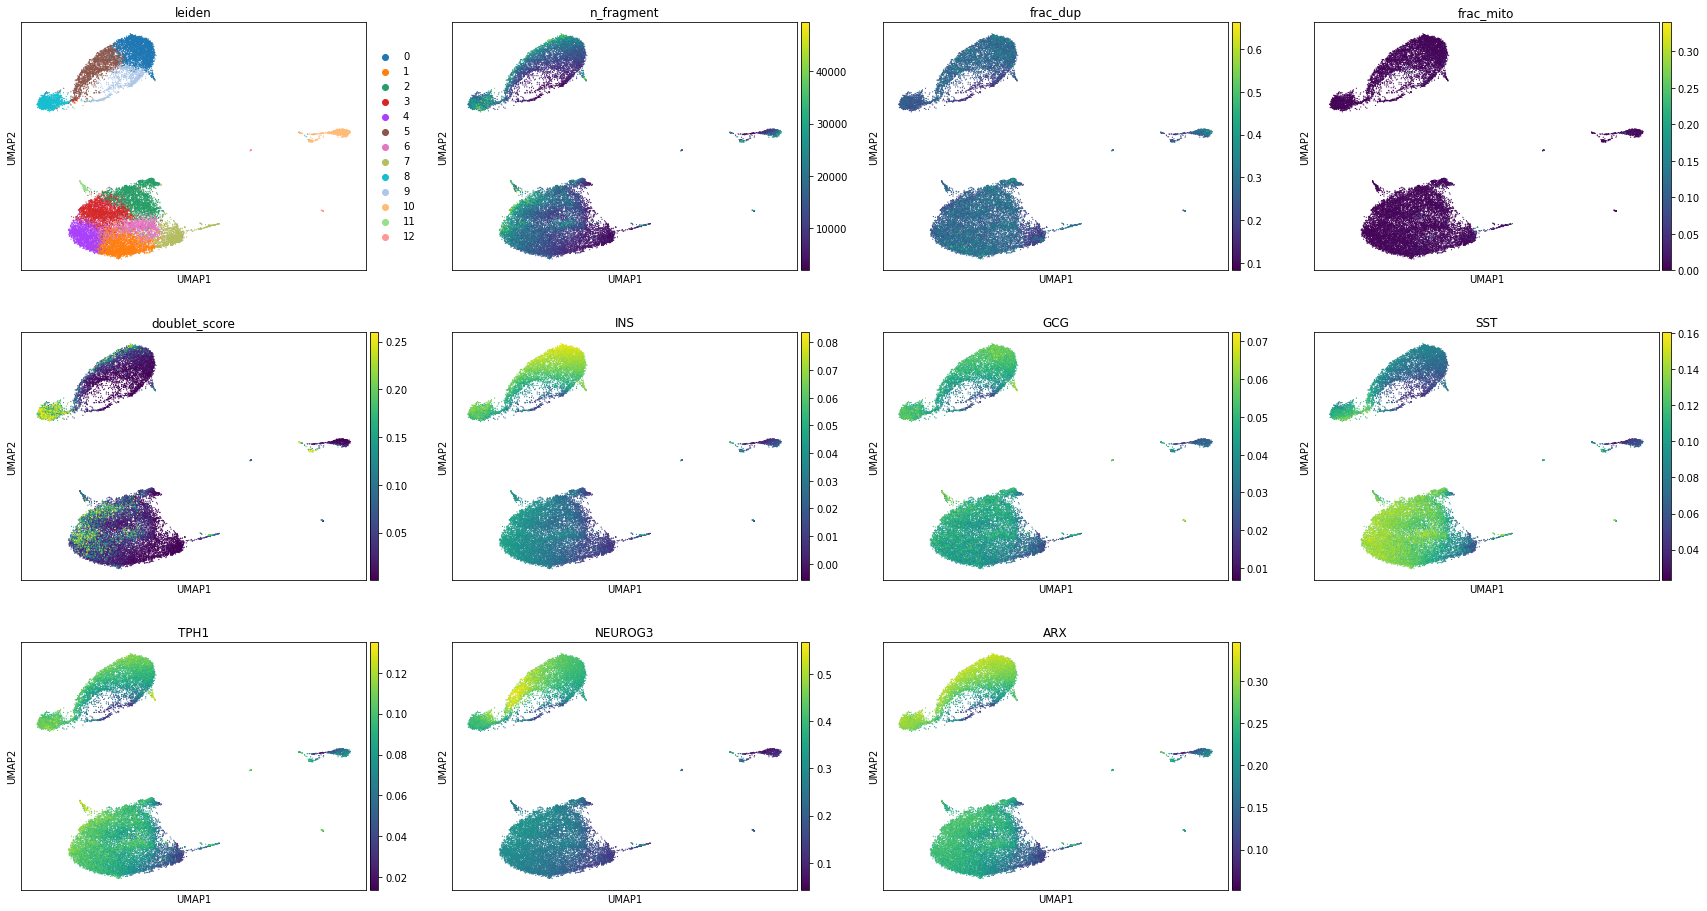

In [43]:
# Plot some technical covariates and marker genes
marker_genes = ['INS', 'GCG', 'SST', 'TPH1', 'NEUROG3', 'ARX']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden", "n_fragment", "frac_dup", "frac_mito", "doublet_score"] + marker_genes)

In [34]:
# Save the gene matrix
gene_matrix.write(os.path.join(outdir_path, f"gene_matrix.h5ad"))

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


# DONE!

---